# Navigating Cost Tradeoffs using Heuristics

Every time we trade, we incur a cost. We pay a commission to the exchange or broker, we cross spreads, and we might even have market impact to contend with. 

A common issue in quant trading is to find an edge, only to discover that if you executed it naively, you'd get killed with costs. 

In this article, I'll show you an example of using a simple heuristic that helps you do an optimal amount of trading to realise your edge in the face of costs. 

A heuristic is a simple rule or shortcut to help make decisions. And this one doesn't involve any fancy math or portfolio optimisation and is quite effective. 

This article continues our recent stat arb series. The previous articles are linked below:
- [A short take on stat arb trading in the real world](https://robotwealth.com/a-short-take-on-real-world-pairs-trading/)
- [A general approach for exploiting stat arb alphas](https://robotwealth.com/a-general-approach-for-exploiting-statistical-arbitrage-alphas/)
- [Ideas for crypto stat arb features](https://robotwealth.com/ideas-for-crypto-stat-arb-features/)
- [Quantifying and combining crypto alphas](https://robotwealth.com/quantifying-and-combining-crypto-alphas/)

In the last article, we combined three crypto features that resulted in some nice theoretical returns using an untradeable model (it was based on a universe of 200+ perpetual futures contracts and didn't consider costs - its purpose was to simply explore and understand the features, not simulate trading them in the real world).

This time we'll consider costs and constrain the universe so that it would be operationally feasible to trade. And we'll use an accurate backtest to explore the various trade offs. 

Let's get to it. 

First, we load the relevant libraries and set our session options. 

You'll notice I install and load an R package called `rsims`. 

This is a backtesting engine for R that I developed. You can find it on GitHub [here](https://github.com/Robot-Wealth/rsims).

A lot of people reading this will ask “Why do we need another backtester?” Which is a fair reaction. I wrote this one because there was nothing that really did what I needed:
- I wanted something that ran super fast to allow me to quickly explore real-world trade-offs in execution (it does a 10-year simulation on a universe of 250 assets 
in 650 milliseconds on my machine).
- I wanted something that would take the outputs of a typical quant research process in R and use them as inputs to a backtest with minimal intervening steps.

I'll show you how to use it in this post. 

In [34]:
# session  options
options(repr.plot.width = 14, repr.plot.height=7, warn = -1)

pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = TRUE)  # this will take some time the first time you build the package
library(rsims)
library(tidyverse)
library(tibbletime)
library(roll)
library(patchwork)

# chart options
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Next, read our perpetual futures data. This is the same [data](https://github.com/Robot-Wealth/r-quant-recipes/raw/master/quantifying-combining-alphas/binance_perp_daily.csv) used previously in this series, but this time we are a bit more careful with our universe:
- Remove any stablecoins
- Trade only the top 30 coins by trailing 30-day volume

In [35]:
perps <- read_csv("https://github.com/Robot-Wealth/r-quant-recipes/raw/master/quantifying-combining-alphas/binance_perp_daily.csv")
head(perps)

Rows: 187251 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (9): open, high, low, close, dollar_volume, num_trades, taker_buy_volum...
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ticker,date,open,high,low,close,dollar_volume,num_trades,taker_buy_volume,taker_buy_quote_volumne,funding_rate
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2019-09-11,10172.13,10293.11,9884.31,9991.84,85955369,10928,5169.153,52110075,-3e-04
BTCUSDT,2019-09-12,9992.18,10365.15,9934.11,10326.58,157223498,19384,11822.980,119810012,-3e-04
BTCUSDT,2019-09-13,10327.25,10450.13,10239.42,10296.57,189055129,25370,9198.551,94983470,-3e-04
BTCUSDT,2019-09-14,10294.81,10396.40,10153.51,10358.00,206031349,31494,9761.462,100482121,-3e-04
BTCUSDT,2019-09-15,10355.61,10419.97,10024.81,10306.37,211326874,27512,7418.716,76577710,-3e-04
BTCUSDT,2019-09-16,10306.79,10353.81,10115.00,10120.07,208211376,29030,7564.376,77673986,-3e-04


In [36]:
# remove stablecoins
# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  httr::content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# sort(stables)

perps <- perps %>% 
  filter(!ticker %in% glue::glue("{stables}USDT")) 

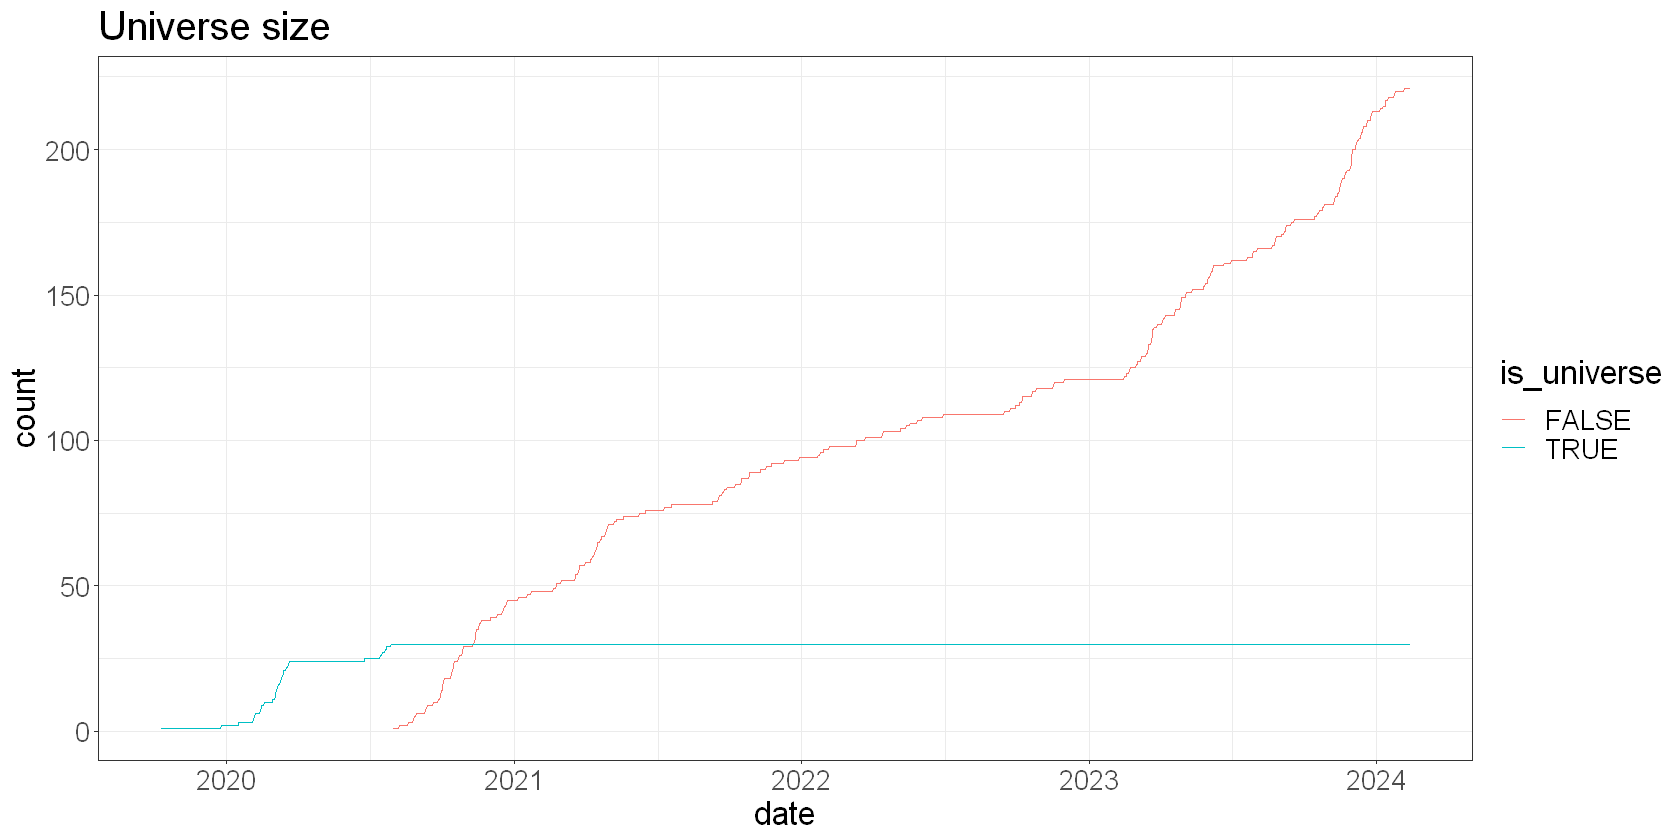

In [37]:
# just get the top 30 by trailing 30-day volume
trading_universe_size <- 30

universe <- perps %>%
  group_by(ticker) %>% 
  mutate(trail_volume = roll_mean(dollar_volume, 30)) %>% 
  na.omit() %>% 
  group_by(date) %>%
  mutate(
    volume_rank = row_number(-trail_volume),
    is_universe = volume_rank <= trading_universe_size
  ) 

universe %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  ggplot(aes(x=date, y=count, color = is_universe)) + 
  geom_line() + 
  labs(
    title = 'Universe size'
)

The plot shows that we have 30 assets in our universe from mid 2020 (and of course, those assets will change through time). 

Next, calculate our features as before:

In [38]:
# calculate features
rolling_days_since_high_20 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    }, 
    window = 20, na_value = NA), 
  otherwise = NA
)

features <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    breakout = lag(9.5 - rolling_days_since_high_20(close)),  # puts this feature on a scale -9.5 to +9.5
    momo = lag(close - lag(close, 10)/close),
    carry = lag(funding_rate)
  ) %>%
  ungroup() %>% 
  na.omit()

head(features)

ticker,date,open,high,low,close,dollar_volume,num_trades,taker_buy_volume,taker_buy_quote_volumne,funding_rate,trail_volume,volume_rank,is_universe,breakout,momo,carry
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>
BTCUSDT,2019-10-30,9352.65,9492.86,8975.72,9102.91,1089606006,267844,58062.12,537610627,-0.00106636,660931006,1,TRUE,7.5,9353.776,-0.00117130
BTCUSDT,2019-10-31,9103.86,9438.64,8933.00,9218.70,851802094,229216,46234.79,423883668,-0.00092829,680429873,1,TRUE,6.5,9102.029,-0.00106636
BTCUSDT,2019-11-01,9218.70,9280.00,9011.00,9084.37,816001159,233091,43506.69,398347973,-0.00074601,698120233,1,TRUE,5.5,9217.811,-0.00092829
BTCUSDT,2019-11-02,9084.37,9375.00,9050.27,9320.00,653539543,204338,35617.67,328788833,-0.00030000,710903610,1,TRUE,4.5,9083.466,-0.00074601
BTCUSDT,2019-11-03,9319.00,9366.69,9105.00,9180.97,609237501,219662,31698.32,292888566,-0.00030000,722483703,1,TRUE,3.5,9319.204,-0.00030000
BTCUSDT,2019-11-04,9180.97,9320.00,9073.00,9292.66,631763431,211571,34375.10,316185069,-0.00030072,735726657,1,TRUE,2.5,9180.160,-0.00030000


Next combine our features into target weights as before, but we also need prices and funding rates for backtesting purposes (previously we just summed total log returns, but this time we're actually going to backtest on prices and funding rates).

In [39]:
# calculate target weights
# filter on is_universe so that we calculate features only for stuff that's in the universe today 
# (we'd have to do this differently if any of these calcs depended on past data, eg if we were doing z-score smoothing)
# then, join on original prices for backtesting

# tickers that were ever in the universe
universe_tickers <- features %>%
  filter(is_universe) %>%
  pull(ticker) %>%
  unique()

# print(length(universe_tickers))

# start simulation from date we first have n tickers in the universe
start_date <- features %>%
  group_by(date, is_universe) %>%
  summarize(count = n(), .groups = "drop") %>%
  filter(count >= trading_universe_size) %>%
  head(1) %>%
  pull(date)

# calculate weights
model_df <- features %>%
  filter(is_universe) %>% 
  group_by(date) %>%
  mutate(
    carry_decile = ntile(carry, 10),
    carry_weight = (carry_decile - 5.5),  # will run -4.5 to 4.5
    momo_decile = ntile(momo, 10),
    momo_weight = -(momo_decile - 5.5),  # will run -4.5 to 4.5
    breakout_weight = breakout / 2,  
    combined_weight = (0.5*carry_weight + 0.2*momo_weight + 0.3*breakout_weight),
    # scale weights so that abs values sum to 1 - no leverage condition
    scaled_weight = combined_weight/sum(abs(combined_weight))
  )  %>% 
  select(date, ticker, scaled_weight) %>% 
  # join back onto df of prices for all tickers that were ever in the universe
  # so that we have prices before and after a ticker comes into or out of the universe
  # for backtesting purposes
  right_join(
    features %>% 
      filter(ticker %in% universe_tickers) %>% 
      select(date, ticker, close, funding_rate), 
    by = c("date", "ticker")
  ) %>% 
  # give anything with a NA weight (due to the join) a zero
  replace_na(list(scaled_weight = 0)) %>%
  arrange(date, ticker) %>%
  filter(date >= start_date)

## Introducing rsims

Event based simulators are typically slow because each loop through the trading logic depends on the output of the previous one. 

`rsims` is so fast because it takes a quasi-event based approach and relies on the user to correctly date-align prices, target weights and funding rates. Specifically, it assumes that `target_weights` are date-aligned with `prices` such that the price at which you assume you trade into a target weight has the same index value.

That means that you need to lag your features relative to your prices. And for Binance perpetuals, you'll need to do the opposite - lag prices relative to funding rates. You also need to ensure that funding rate represents funding to *long* positions, which may not be the default for many exchanges. 

This takes a little thought and some data wrangling upstream, however, this is often a natural output of the research process, so this workflow can be quite efficient. 

`rsims` also leverages all the usual tricks to speed things up - using efficient data structures (matrixes instead of dataframes), preallocating memory, and offloading any bottlenecks to C++ rather than R. 

A simple way to get the date-aligned prices, weights, and funding matrixes from our dataframes is to use `dplyr::pivot_wider`. If you use your date column as the `id_cols` argument, you're guaranteed to have the other variables correctly date-aligned (with NA for any variable missing on a particular date).

In [40]:
# get weights as a wide matrix 
# note that date column will get converted to unix timestamp
backtest_weights <- model_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, scaled_weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("scaled_weight")) %>%
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

head(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- model_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, scaled_weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(date, starts_with("close_")) %>%
  data.matrix()

head(backtest_prices, c(5, 5))

# get funding as a wide matrix
# note that date column will get converted to unix timestamp
backtest_funding <- model_df %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = c(close, funding_rate)) %>%  # pivot wider guarantees prices and funding_returns_simple are date aligned
  select(date, starts_with("funding_rate_")) %>%
  data.matrix()

head(backtest_funding, c(5, 5))

date,scaled_weight_ADAUSDT,scaled_weight_ALGOUSDT,scaled_weight_ATOMUSDT,scaled_weight_AVAXUSDT
18577,-0.05340376,0,-0.08157277,-0.036971831
18578,-0.04981025,0,-0.03083491,-0.013757116
18579,-0.04385542,0,-0.04385542,-0.036144578
18580,0.01767389,0,-0.04047891,0.009692132
18581,0.02675386,0,0.00000000,-0.029131986


date,close_ADAUSDT,close_ALGOUSDT,close_ATOMUSDT,close_AVAXUSDT
18577,0.10815,0.2823,5.069,3.5881
18578,0.10467,0.2647,5.091,3.4029
18579,0.10643,0.2759,5.200,3.5428
18580,0.10298,0.2668,5.068,3.4840
18581,0.10298,0.2712,5.088,3.6066


date,funding_rate_ADAUSDT,funding_rate_ALGOUSDT,funding_rate_ATOMUSDT,funding_rate_AVAXUSDT
18577,-0.00125424,-0.00030000,-0.00030000,-0.00030000
18578,-0.00065454,-0.00038655,-0.00030000,-0.00030000
18579,-0.00061317,-0.00045249,-0.00030000,-0.00022094
18580,-0.00030000,-0.00092204,-0.00039684,-0.00030000
18581,-0.00132094,-0.00133458,0.00000783,-0.00030000


Next, prior to running some simulations, here are some helper objects and functions for modelling costs on Binance and plotting results:

In [41]:
# fees - reasonable approximation of actual binance costs (spread + market impact + commission)
fees <- tribble(
  ~tier, ~fee,
  0, 0.,  # use for cost-free simulations
  1, 0.0015,
  2, 0.001,
  3, 0.0008,
  4, 0.0007,
  5, 0.0006,
  6, 0.0004,
  7, 0.0002
)

# make a nice plot with some summary statistics
# plot equity curve from output of simulation
plot_results <- function(backtest_results, weighting_protocol = "0.5/0.2/0.3 Carry/Momo/Breakout", trade_on = "close") {
  margin <- backtest_results %>%
    group_by(Date) %>%
    summarise(Margin = sum(Margin, na.rm = TRUE))

  cash_balance <- backtest_results %>%
    filter(ticker == "Cash") %>%
    select(Date, Value) %>%
    rename("Cash" = Value)

  equity <- cash_balance %>%
    left_join(margin, by = "Date") %>%
    mutate(Equity = Cash + Margin)

  fin_eq <- equity %>%
    tail(1) %>%
    pull(Equity)

  init_eq <- equity %>%
    head(1) %>%
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- nrow(equity)
  ann_return <- total_return * 365/days
  sharpe <- equity %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(365)*mean(returns)/sd(returns)) %>%
    pull()

  equity %>%
    ggplot(aes(x = Date, y = Equity)) +
      geom_line() +
      labs(
        title = "Crypto Stat Arb Simulation",
        subtitle = glue::glue(
          "{weighting_protocol}, costs {commission_pct*100}% of trade value, trade buffer = {trade_buffer}, trade on {trade_on}
          {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
        )
      )
}

# calculate sharpe ratio from output of simulation
calc_sharpe <- function(backtest_results) {
  margin <- backtest_results %>%
    group_by(Date) %>%
    summarise(Margin = sum(Margin, na.rm = TRUE))

  cash_balance <- backtest_results %>%
    filter(ticker == "Cash") %>%
    select(Date, Value) %>%
    rename("Cash" = Value)

  equity <- cash_balance %>%
    left_join(margin, by = "Date") %>%
    mutate(Equity = Cash + Margin)

equity %>% 
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()
}

## Introducing our heuristic for reducing trading: the no-trade buffer

Before we get to our simulations, let's discuss our heuristic for reducing our trading.

Finding alphas is one thing, but an extremely important skill in trading is managing them together, in particular managing turnover. The no-trade buffer is a simple heuristic for managing this. 

Since we always trade uncertain edges in the face of certain costs, our goal is to do only the minimum amount of trading required to harness the edge. 

In the no-trade buffer approach, positions are rebalanced once they deviate from their target by more than a parameter, `trade_buffer`. That is, we have a "no-trade region" around our target position that is twice `trade_buffer`, and we trade only when our positions get more out of whack. 

[@macrocephalopod on Twitter/X gives a derivation of the trade buffer parameter](https://twitter.com/macrocephalopod/status/1373236950728052736) that allows it to be extended to cases where you want to include co-movement of assets or force more aversion to trading.

Rebalancing happens slightly differently depending on the commission model used:  

- For minimum commission trading (for instance equities trading with Interactive Brokers), rebalance back to the target weight  
- For fixed commission trading (for instance futures and most crypto exchanges), rebalance back to the target weight plus/minus the trade buffer  

There are a few different ways to decide on the `trade_buffer` parameter. For instance, you can set it to target a certain portfolio turnover. Or, you can find the value that optimises the Sharpe ratio of a backtest that includes costs. Here we'll take the latter approach. 

`rsims` implements the no-trade buffer approach for crypto perpetual futures with the backtesting function `rsims::fixed_commission_backtest_with_funding`.

First, let's simulate the cost-free version with the `trade_buffer` set to zero. This is the same as trading the signal precisely - always rebalancing back to our target positions. We invest a constant $10,000 and don't use leverage.

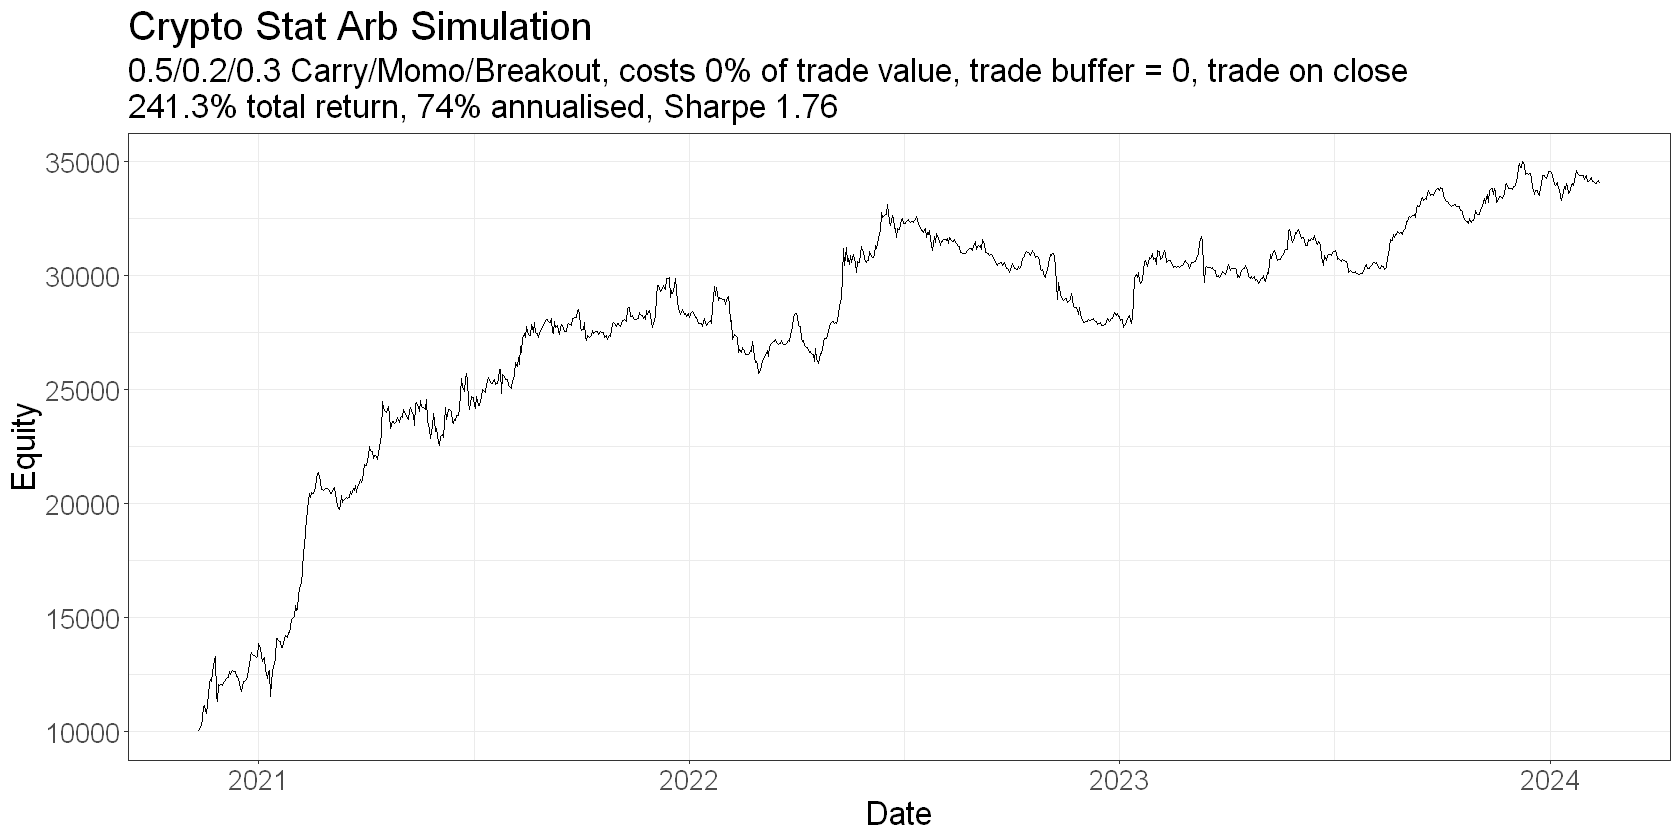

In [42]:
# cost-free, no trade buffer
# simulation parameters
initial_cash <- 10000
fee_tier <- 0
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]
margin <- 0.05

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>%
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

plot_results(results_df)

In [43]:
# check that actual weights match intended (can trade fractional contracts, so should be equal)
results_df %>%
  left_join(model_df %>% select(ticker, date, scaled_weight), by = c("ticker", "Date" = "date")) %>%
  group_by(Date) %>%
  mutate(
    actual_weight = Value/(initial_cash)
  )  %>%
  filter(scaled_weight != 0) %>%
  tail(10)

ticker,Date,Close,Position,Value,Margin,Funding,PeriodPnL,Trades,TradeValue,Commission,MarginCall,ReducedTargetPos,scaled_weight,actual_weight
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CFXUSDT,2024-02-13,0.2192000,-1.070045e+03,-234.55378,11.727689,0.06922776,0.1405190,-7.135885e+02,-156.41860,0,0,0,-0.023455378,-0.023455378
ARBUSDT,2024-02-13,2.0327000,5.347353e+01,108.69565,5.434783,-0.02059611,0.8541669,1.969890e+01,40.04195,0,0,0,0.010869565,0.010869565
BLURUSDT,2024-02-13,0.6817000,-2.601519e+02,-177.34554,8.867277,0.09084505,-7.3657998,-1.191945e+02,-81.25490,0,0,0,-0.017734554,-0.017734554
SUIUSDT,2024-02-13,1.7847000,3.814524e+02,680.77803,34.038902,-0.20855505,1.5443030,-8.071655e+00,-14.40548,0,0,0,0.068077803,0.068077803
UMAUSDT,2024-02-13,4.2210000,5.014700e+01,211.67048,10.583524,0.34515420,59.8849311,1.879706e+02,793.42372,0,0,0,0.021167048,0.021167048
SEIUSDT,2024-02-13,0.7359000,3.809218e+02,280.32037,14.016018,-0.20655005,13.9411664,-2.797172e+01,-20.58439,0,0,0,0.028032037,0.028032037
TIAUSDT,2024-02-13,19.2523000,3.892667e+01,749.42792,37.471396,0.42387837,-14.1039051,2.579951e+00,49.66999,0,0,0,0.074942792,0.074942792
ORDIUSDT,2024-02-13,67.5660000,-2.794115e+00,-188.78719,9.439359,0.54223212,-14.9955991,2.451608e+00,165.64533,0,0,0,-0.018878719,-0.018878719
PYTHUSDT,2024-02-13,0.5799000,-1.085171e+02,-62.92906,3.146453,-0.03434807,1.5618746,-1.742053e+02,-101.02163,0,0,0,-0.006292906,-0.006292906


Next, let's add costs but keep our `trade_buffer` at zero. We'll assume we pay 0.15% of the value of each trade in costs. 

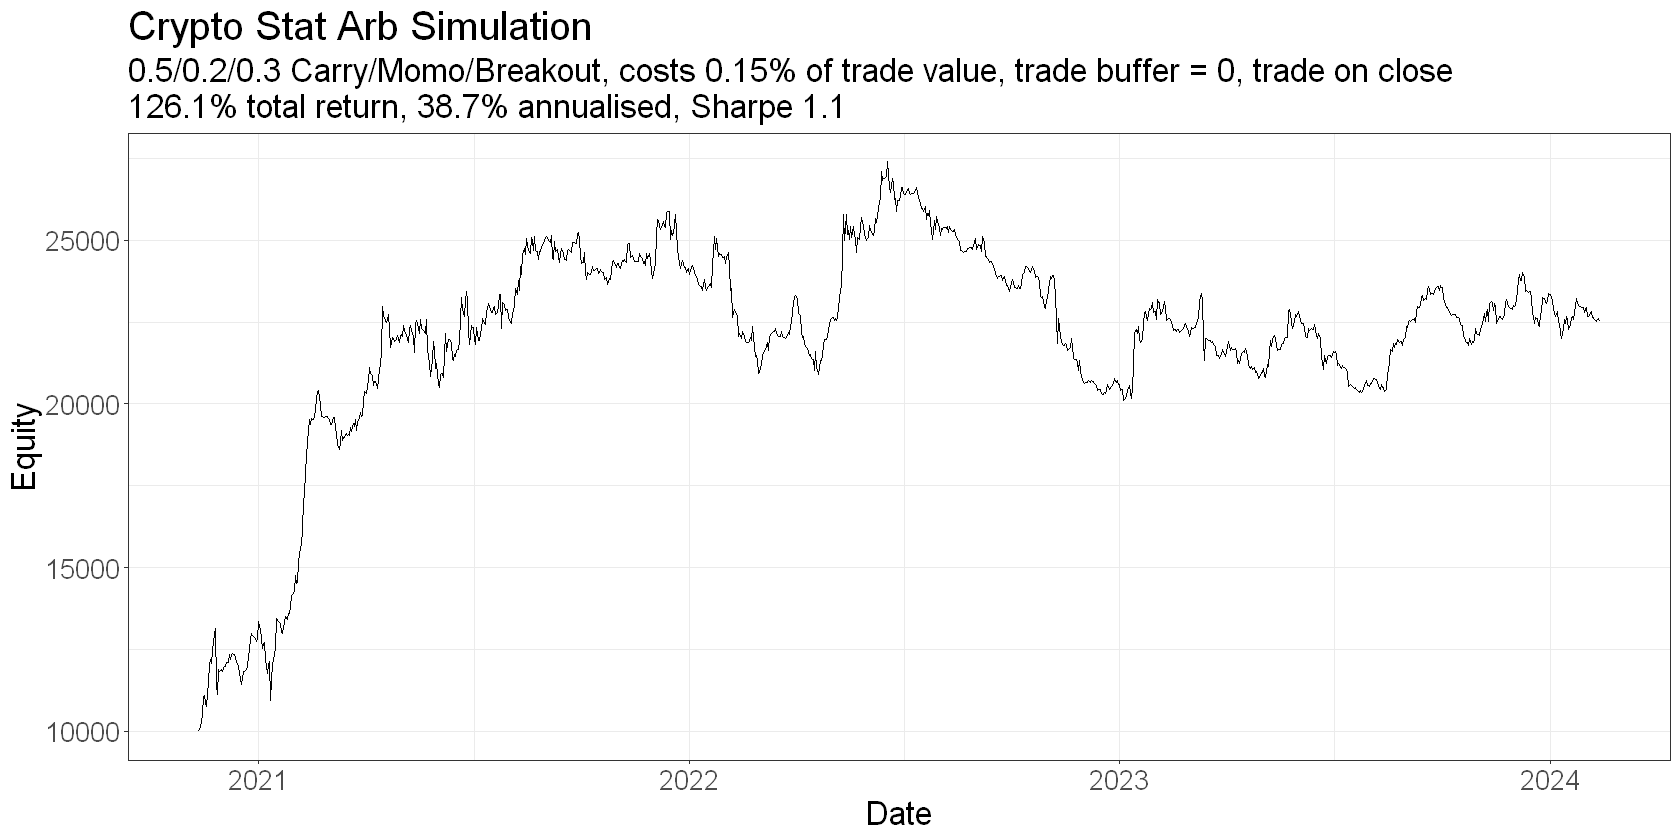

In [44]:
# explore costs-turnover tradeoffs
# with costs, no trade buffer
fee_tier <- 1.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- fixed_commission_backtest_with_funding(
  prices = backtest_prices,
  target_weights = backtest_weights,
  funding_rates = backtest_funding,
  trade_buffer = trade_buffer,
  initial_cash = initial_cash,
  margin = margin,
  commission_pct = commission_pct,
  capitalise_profits = capitalise_profits
  ) %>% 
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

results_df %>%
  plot_results()

The impact of costs is obvious. 

Let's have a look at the turnover of our portfolio. 

First, here's the daily turnover as a percentage of our trading capital:

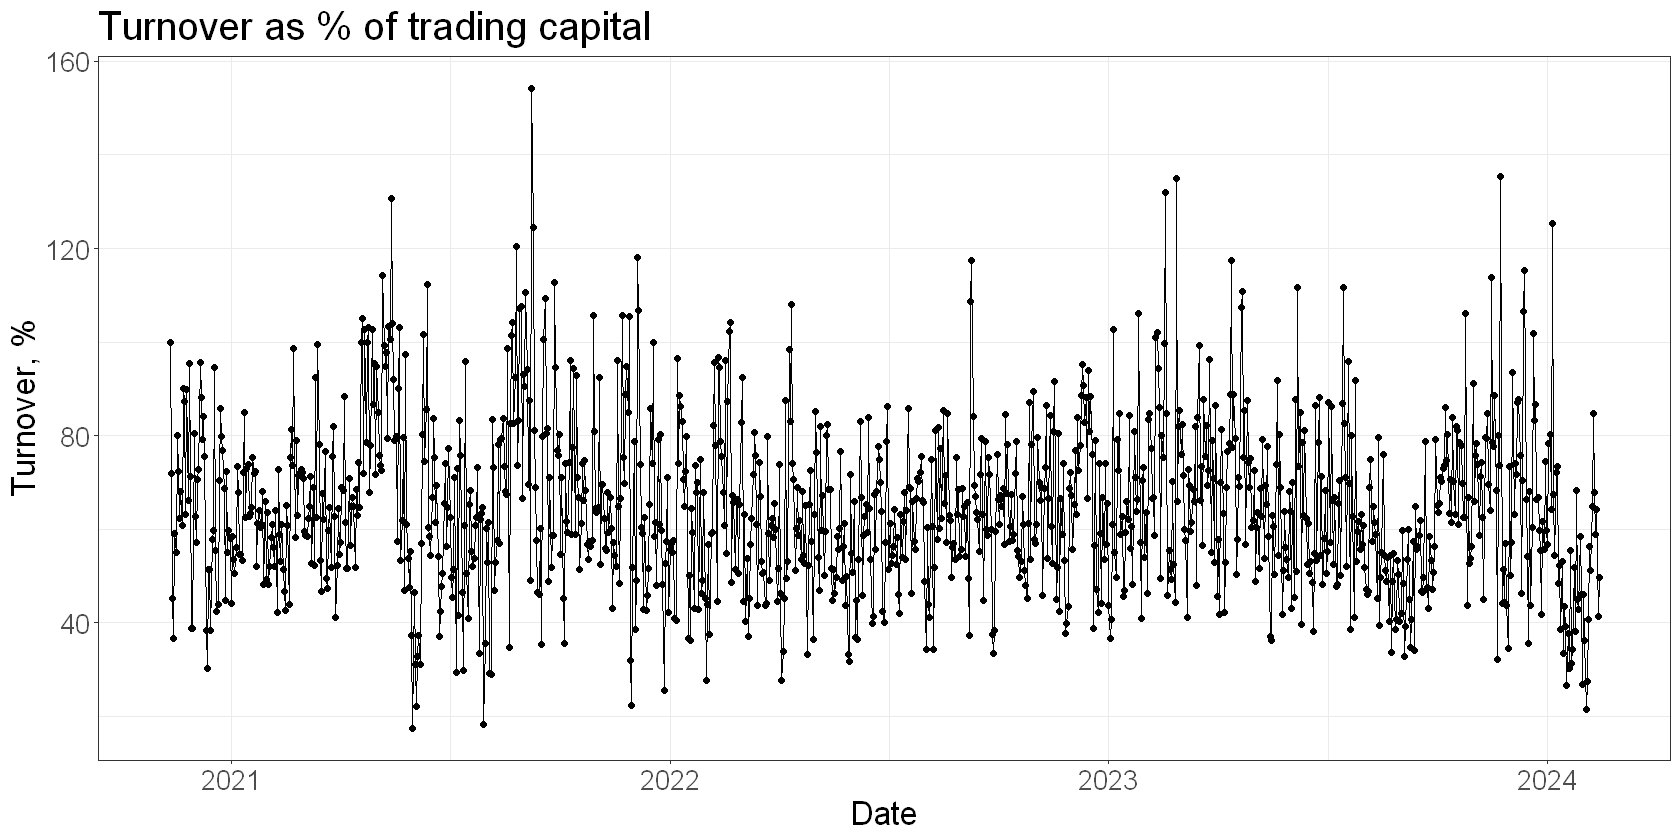

In [45]:
results_df %>%
  filter(ticker != "Cash") %>% 
  group_by(Date) %>% 
  summarise(Turnover = 100*sum(abs(TradeValue))/initial_cash) %>% 
  ggplot(aes(x = Date, y = Turnover)) +
    geom_line() +
    geom_point() +
    labs(
      title = "Turnover as % of trading capital",
      y = "Turnover, %"
    )

You can see that we regularly turnover than half the portfolio on a single day! That's going to cost an absolute ton. 

Here's a plot of dollar turnover by ticker for a few days in February. You can see that we do a ton of small rebalances, which is operationally tedious, expensive, and unlikely to be very valuable. 

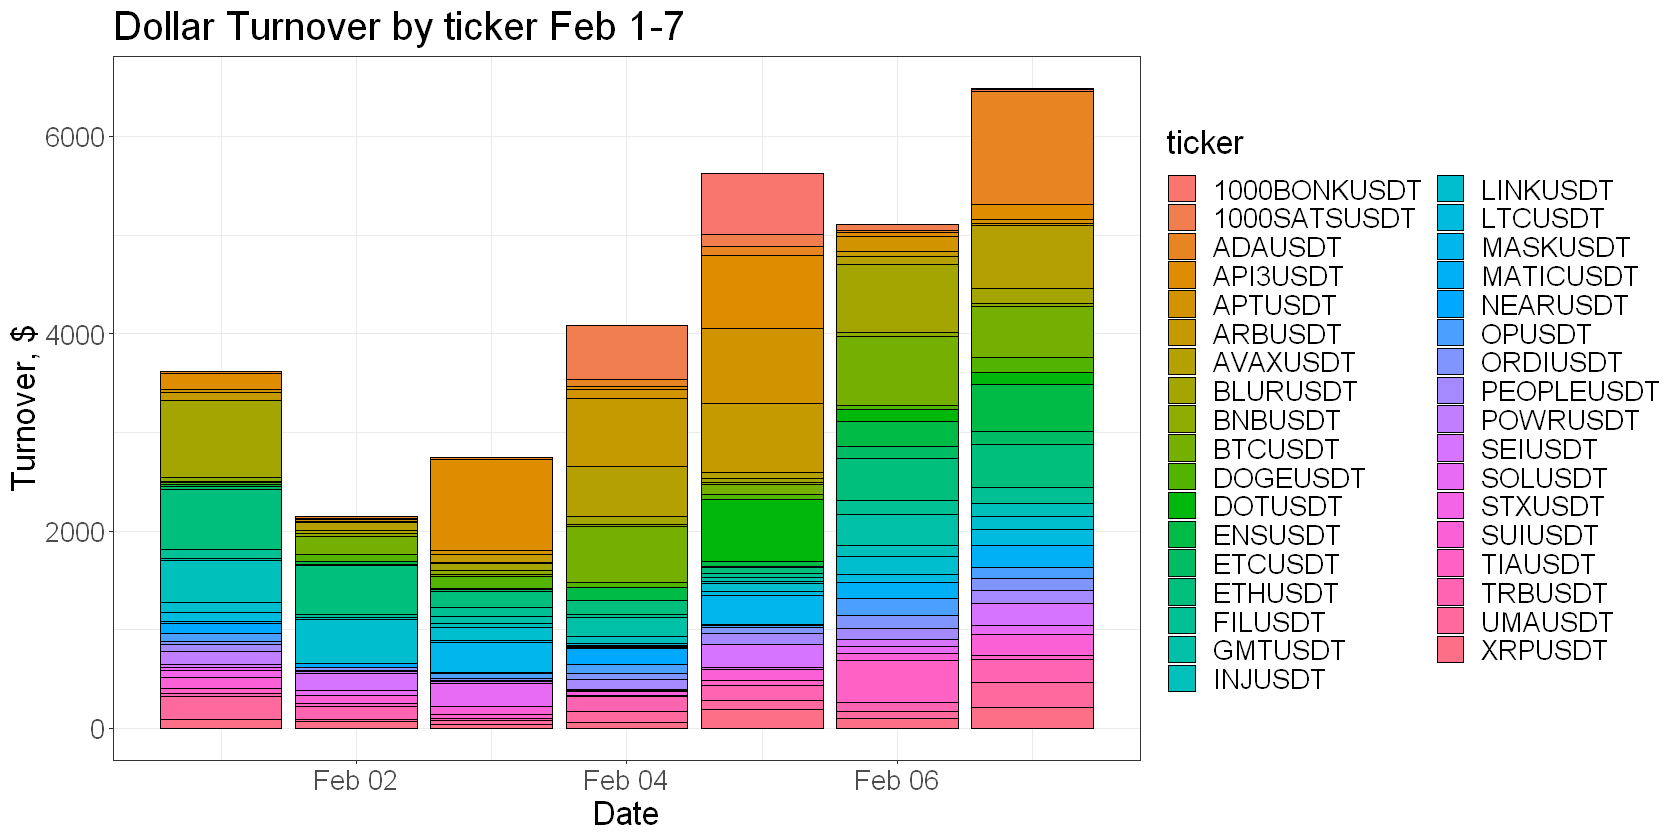

In [46]:
# on a particular few days
results_df %>%
  filter(Date >= "2024-02-01", Date <= "2024-02-07") %>%
  filter(abs(TradeValue) > 0) %>% 
  ggplot(aes(x = Date, y = abs(TradeValue), fill = ticker)) +
    geom_bar(stat = "identity", position = "stack", colour = "black") +
    labs(
        title = "Dollar Turnover by ticker Feb 1-7",
        y = "Turnover, $"
    )

We can reduce this turnover by introducing the no-trade buffer.  

To find a sensible value, find the `trade_buffer` that maximised the historical after-cost Sharpe ratio:

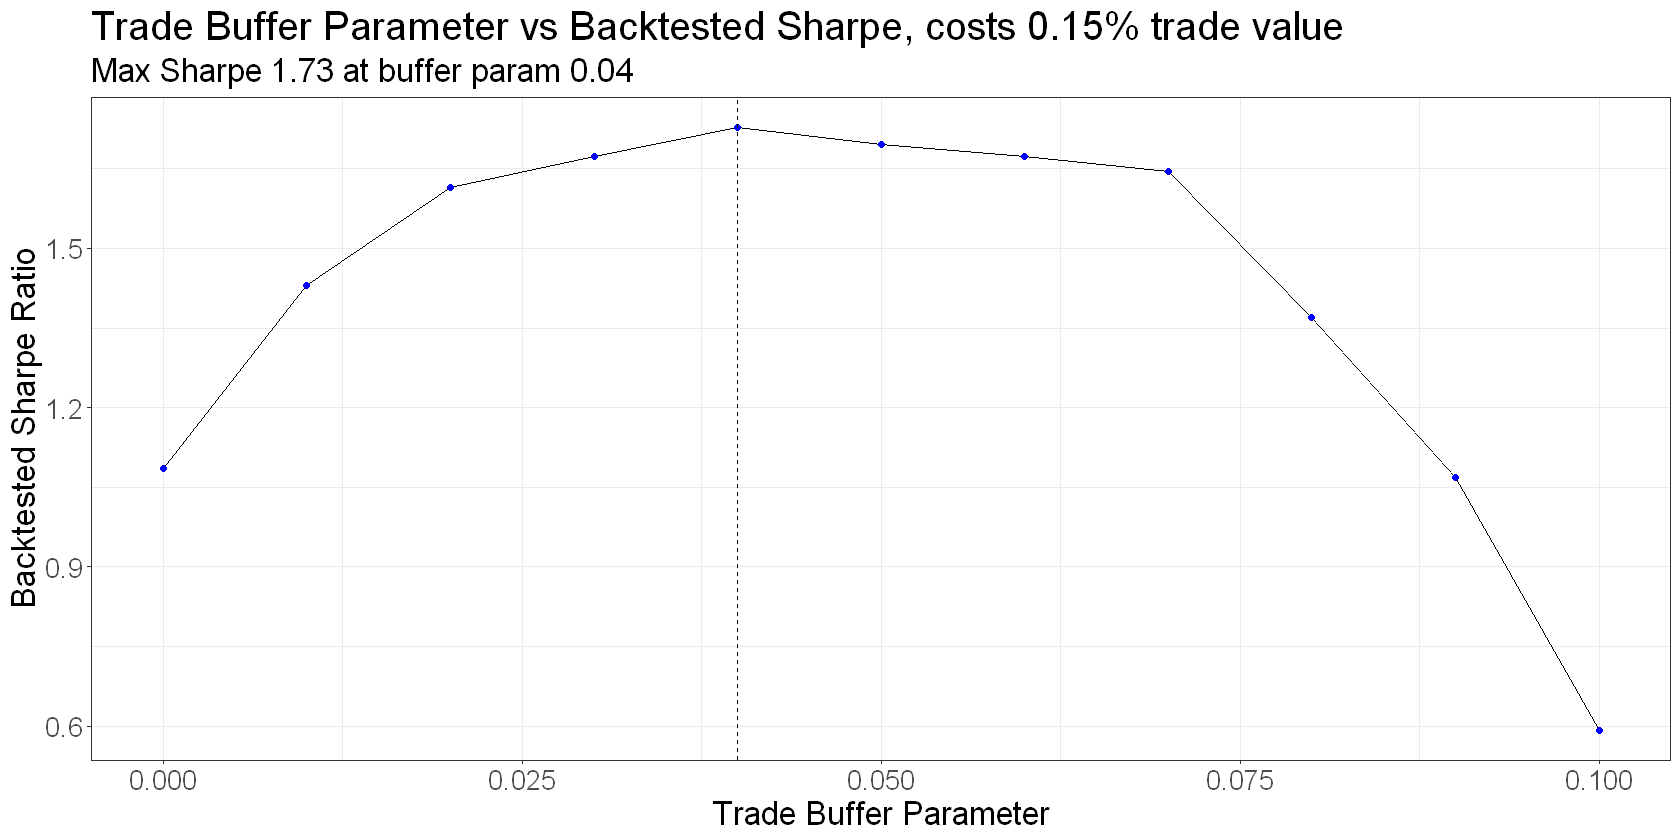

In [47]:
# find appropriate trade buffer by optimising historical sharpe
sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    fixed_commission_backtest_with_funding(
      prices = backtest_prices,
      target_weights = backtest_weights,
      funding_rates = backtest_funding,
      trade_buffer = trade_buffer,
      initial_cash = initial_cash,
      margin = margin,
      commission_pct = commission_pct,
      capitalise_profits = capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue::glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue::glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

A value of 0.04 maximised our historical after-cost Sharpe. Historical performance was quite stable across a decent range. 

You might pick a value a little higher than 0.04 to mitigate the risk that your out-of-sample performance will be worse than your in-sample (almost always a good assumption). But for now, let's just simulate 0.04:

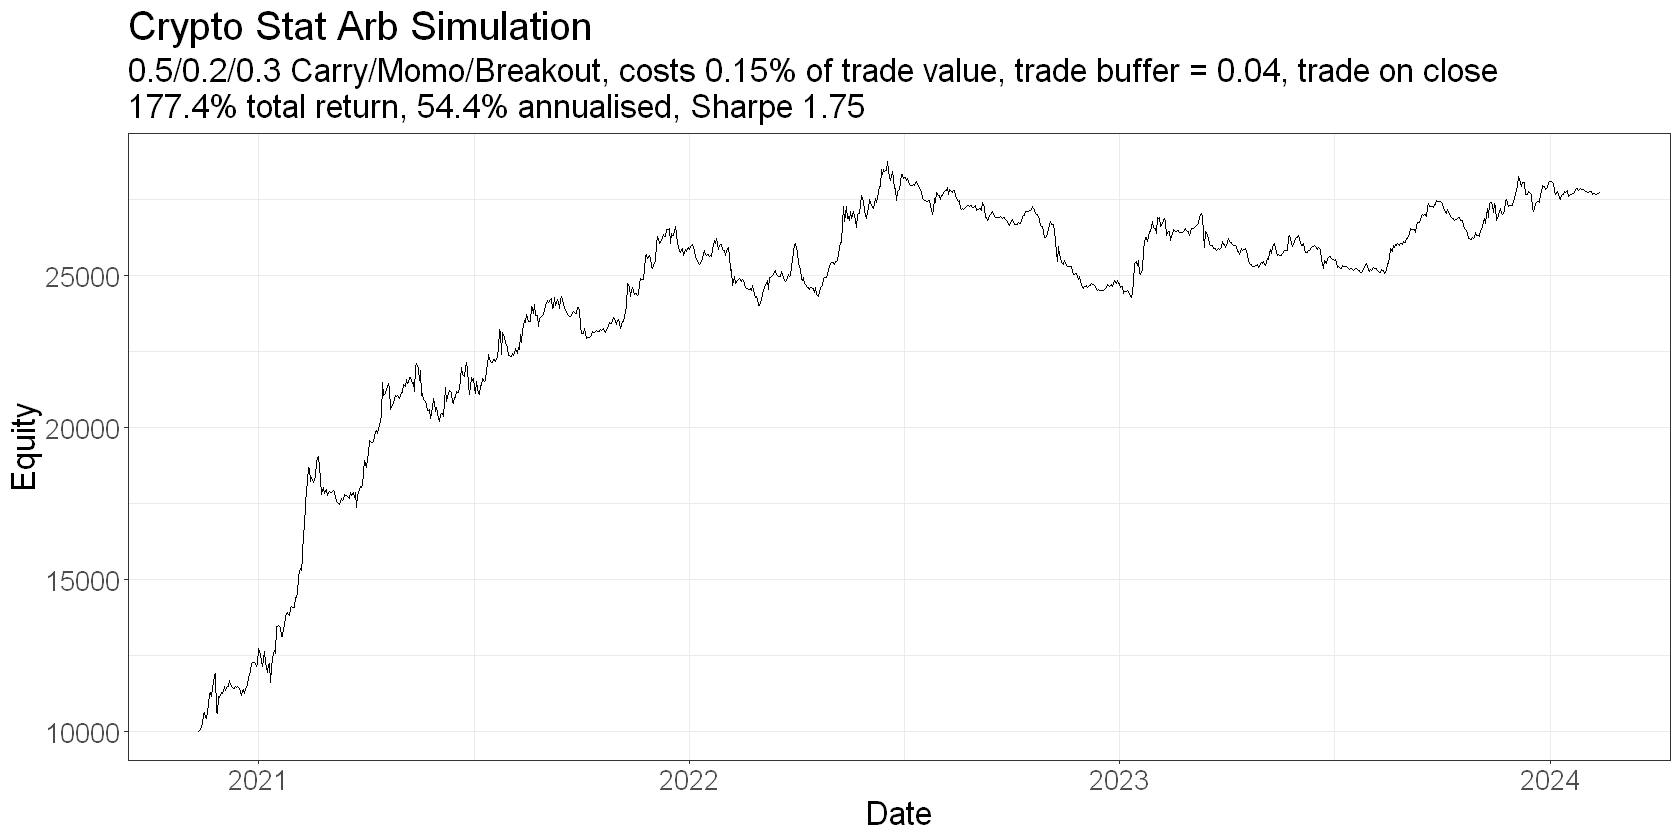

In [48]:
# get back original with costs simulation results
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.04
fee_tier <- 1.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- fixed_commission_backtest_with_funding(
    prices = backtest_prices,
    target_weights = backtest_weights,
    funding_rates = backtest_funding,
    trade_buffer = trade_buffer,
    initial_cash = initial_cash,
    margin = margin,
    commission_pct = commission_pct,
    capitalise_profits = capitalise_profits
  ) %>% 
  mutate(ticker = str_remove(ticker, "close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

# simulation results
results_df %>%
  plot_results()

Let's take a look at the effect on turnover:

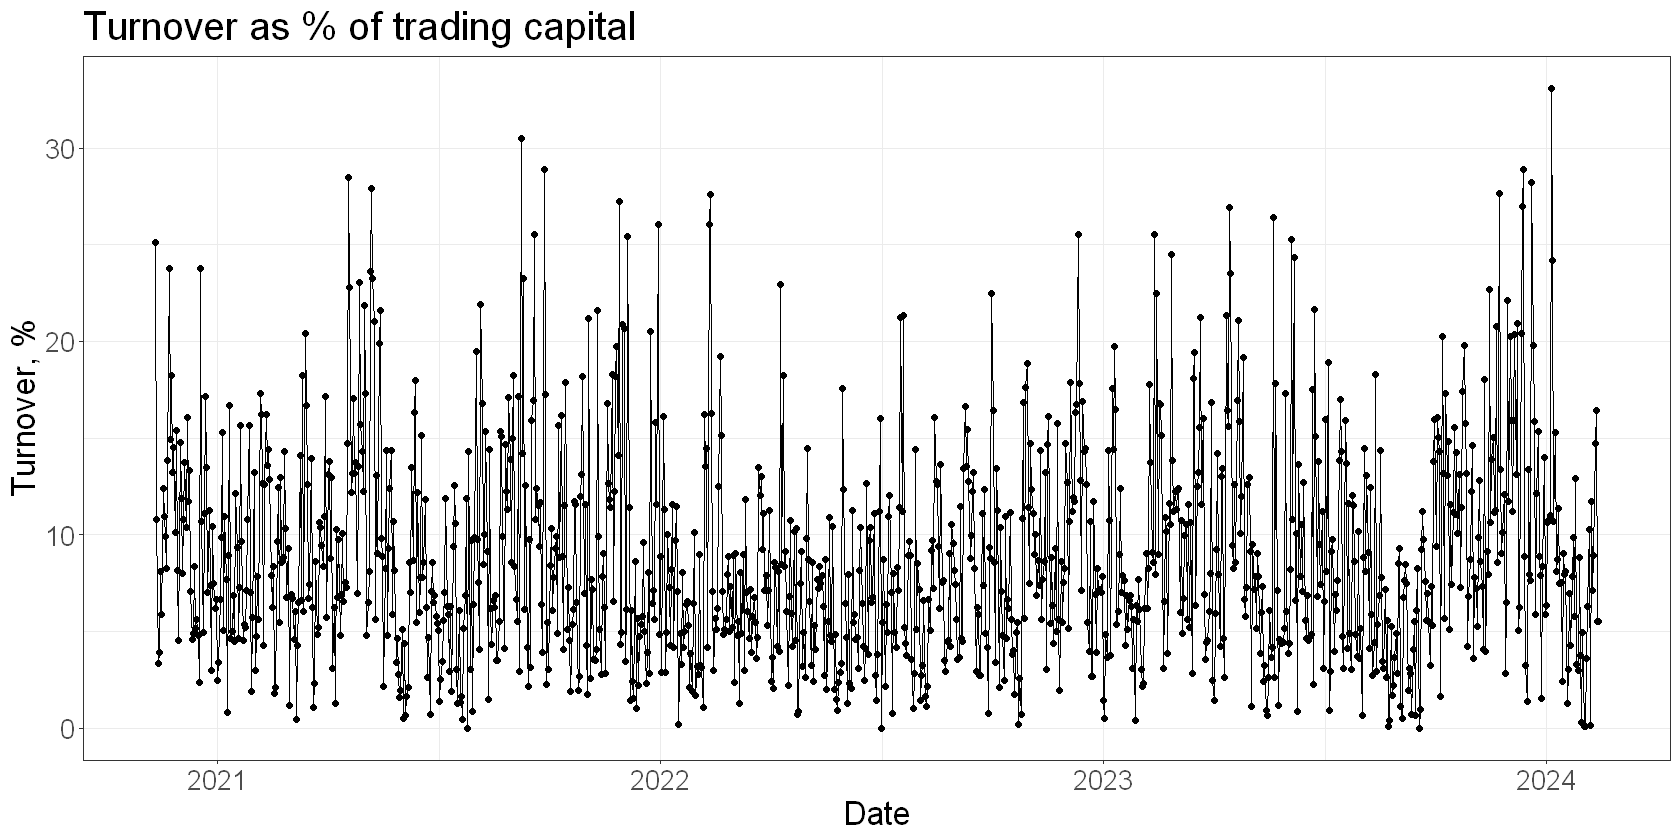

In [49]:
results_df %>%
  filter(ticker != "Cash") %>% 
  group_by(Date) %>% 
  summarise(Turnover = 100*sum(abs(TradeValue))/initial_cash) %>% 
  ggplot(aes(x = Date, y = Turnover)) +
    geom_line() +
    geom_point() +
    labs(
      title = "Turnover as % of trading capital",
      y = "Turnover, %"
    )

You can see that turnover has come way down. 

This is obvious when we plot dollar turnover by ticker for a few days in February. We only do a handful of rebalances each day - this is both cost-effective and operationally efficient. 

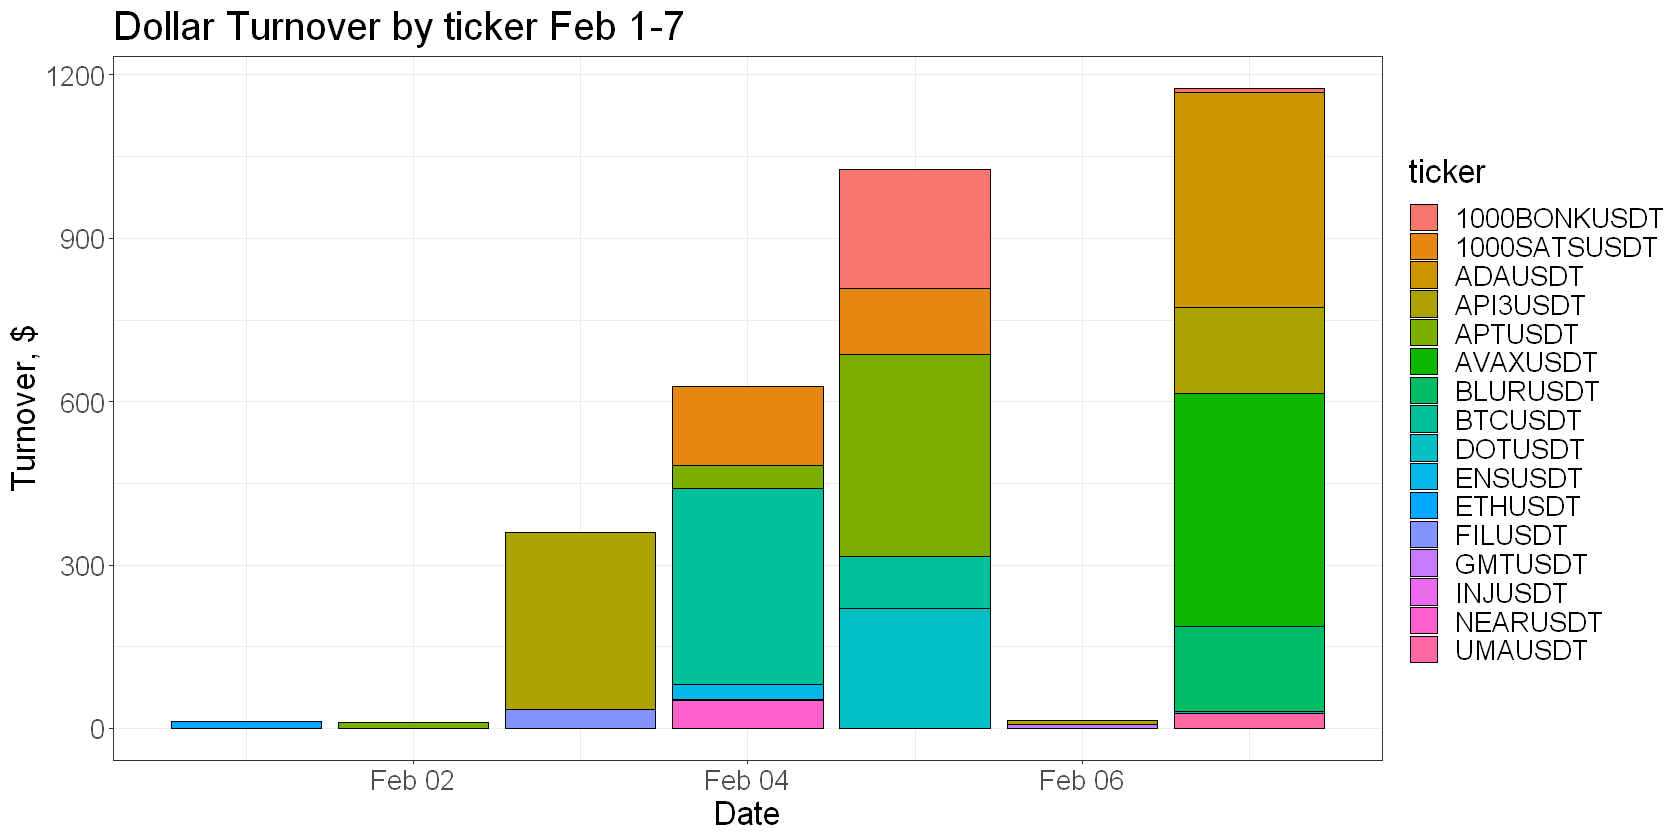

In [50]:
# on a particular few days
results_df %>%
  filter(Date >= "2024-02-01", Date <= "2024-02-07") %>%
  filter(abs(TradeValue) > 0) %>% 
  ggplot(aes(x = Date, y = abs(TradeValue), fill = ticker)) +
    geom_bar(stat = "identity", position = "stack", colour = "black") +
    labs(
        title = "Dollar Turnover by ticker Feb 1-7",
        y = "Turnover, $"
    )

## Conclusion

In this article, we saw an example of managing portfolio turnover with the heuristic no-trade buffer rule that stops you trading until your positions get out of whack with your target positions by a certain amount. 

This is a simple and effective approach that requires no fancy math or optimisation techniques. 

We also introduced the `rsims` package for doing fast, accurate backtests in R. The benefit of `rsims` is that it naturally takes the outputs of a quant research process as the inputs for the backtest, leading to an efficient workflow. 

In the next several articles, we'll explore another approach for managing trading decisions using optimisation techniques. 